In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from nbdev import *
%nbdev_default_export data_div2k

Cells will be exported to srthesis.data_div2k,
unless a different module is specified after an export flag: `%nbdev_export special.module`


# Datasets and preprocessing



In [ ]:
%nbdev_export_internal
from fastai.vision import *
from PIL import Image as PILImage

In [ ]:
%nbdev_export_internal
path_dataset = Path('datasets/DIV2K')
path_hr = path_dataset/'images'
path_lr = path_dataset/'downsc-2x'

# def get_lr_path(img_size): return path_dataset/f"small-{img_size}"
# path_lr_64, path_lr_128, path_lr_256 = get_lr_path(64), get_lr_path(128), get_lr_path(256)

scale = 2

## Process images

Zatím jen pro otestování trénování vezmu DIV2K a sám si ho zmenším a uložím ve špatné JPEG kvalitě. O něco se postará bluring v Learner class, ale cílem je ještě přidat šum a nějaký uvěřitelný blur a následně to porovnat s RealSR datasetem. Pokud tam bude vidět zlepšení, zkusím se posunout k vytváření trénovacího setu uměle pomocí NN.

Pre-resize and pre-deform images fixed LR size for faster data handling. I'll need a few different sizes, because for a fast model training it's useful to gradually increase image size.

I'll use crappifier class for transforming clear HR images into corresponding corrupted LR ones.

In [ ]:
il = ImageImageList.from_folder(path_hr)
il

ImageImageList (900 items)
Image (3, 1344, 2040),Image (3, 1368, 2040),Image (3, 1536, 2040),Image (3, 1356, 2040),Image (3, 1356, 2040)
Path: datasets/DIV2K/images

In [ ]:
%nbdev_export_internal

from PIL import Image as PILImage

def crappify(img, size:int):
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')

# dataset for resizing whole images
class crappifier(object):
    def __init__(self, path_lr, path_hr, size):
        self.path_lr = path_lr
        self.path_hr = path_hr
        self.size = size
        
    def __call__(self, fn, i):
        dest = self.path_lr / fn.relative_to(self.path_hr)
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PILImage.open(fn)
        img = crappify(img, self.size)
        q = random.randint(10, 70)
        img.save(dest, quality=q)
        
#dataset for resizing patches
class crapifier_original(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr

    def __call__(self, fn, i):
        dest = self.path_lr / fn.relative_to(self.path_hr)
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PILImage.open(fn)
        orig_sz = img.size
        targ_sz = tuple(s//scale for s in img.size)
        img = img.resize(targ_sz, resample=PIL.Image.BICUBIC).convert('RGB')
        img = img.resize(orig_sz, resample=PIL.Image.BICUBIC).convert('RGB')
        img.save(dest, quality=100)
        
        

Pre-resize and pre-deform images fixed LR size for faster data handling. I'll need a few different sizes, because for a fast model training it's useful to gradually increase image size.

I'll use crappifier class for transforming clear HR images into corresponding corrupted LR ones.

In [ ]:
%nbdev_export_internal
# create smaller image sets the first time this nb is run
def generate_lr(size):
    p = path_dataset/f"small-{size}"
    if not p.exists(): 
        print(f"Resizing images to {size}px into {p}")
        parallel(crappifier(path_lr=p, path_hr=path_hr, size=size), il.items)        
    return p

# create smaller image sets for patches the first time this nb is run
def generate_patch_lr():
    p = path_dataset/f"lr-patch-{scale}x"
    if not p.exists(): 
        print(f"Downsampling images 2x into {p}")
        parallel(crapifier_original(path_lr=p, path_hr=path_hr), il.items)        
    return p


sets = [64, 128, 256]
lr_paths = []
for size in sets:
    lr_paths += [generate_lr(size)]
    
lr_paths += [generate_patch_lr()]
lr_paths

[PosixPath('datasets/DIV2K/small-64'),
 PosixPath('datasets/DIV2K/small-128'),
 PosixPath('datasets/DIV2K/small-256'),
 PosixPath('datasets/DIV2K/lr-patch-2x')]

## Creating databunch

Functions for obtaining DataBunch (which is serving training batches), including a dummy one for fast testing.

In [ ]:
%nbdev_export_internal

def _get_src(path_lr,
             keep_pct: float = 1.0, 
             random_seed: int = 42):
    
    il = ImageImageList.from_folder(path_lr)
    
    if keep_pct < 1.0:
        il = il.use_partial_data(sample_pct=keep_pct, seed=random_seed)
    
    return (il.split_by_folder(train="Train", valid="Validation"))



def _get_tfms(y_size:int):
    crop_rand_patches = crop(size=(y_size,y_size),  row_pct=(0,1), col_pct=(0,1))# pct 
    #TODO brightness and contrast
    #TODO noise
    return [[crop_rand_patches, dihedral_affine()], crop_rand_patches]
    

In [ ]:
%nbdev_export
"""Obtain DataBunch for given target image size and batch size"""
def get_data_div2k(y_size,
             bs,
             keep_pct: float = 1.0,
             xtra_tfms=[],
             random_seed: int = 43,
             stats: tuple = imagenet_stats) -> ImageDataBunch:

    lr_path = generate_patch_lr()
    
    src = _get_src(lr_path, keep_pct, random_seed)

    data = (
        src.label_from_func(lambda x: path_hr/x.parent.parts[-1]/x.name)
           .transform(
               _get_tfms(y_size), 
               size=None, 
               tfm_y=True)
           .databunch(bs=bs)
           .normalize(imagenet_stats, do_y=True)
    )
    data.c = 3
    return data

Show some example inputs and targets in task

$ {LR}_{128px} -> {HR}_{256px} $

Show some example inputs and targets in task

$ {LR}_{256px} -> {HR}_{512px} $

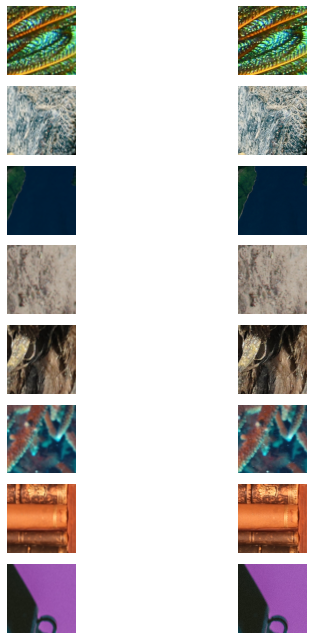

In [ ]:
data = get_data_div2k(128, 8)
data.show_batch(ds_type=DatasetType.Train, rows=8, figsize=(9,9))

In [ ]:
%nbdev_hide
notebook2script()

Converted 00_core.ipynb.
Converted 01_utils.ipynb.
Converted 0__template.ipynb.
Converted 10_data.ipynb.
Converted 11_div2k.ipynb.
Converted 12_realsr.ipynb.
Converted 20_metrics.ipynb.
Converted 21_loss.ipynb.
Converted 22_callbacks.ipynb.
Converted 23_tensorboard.ipynb.
Converted 31_generator_learner.ipynb.
Converted 32_critic_learner.ipynb.
Converted 41_generator_pretraining.ipynb.
Converted 42_critic_pretraining.ipynb.
Converted 43_gan_training.ipynb.
Converted augmentations.ipynb.
Converted sr reference.ipynb.
